# Web Scraping and Data Processing

Web Scraping basics

In [1]:
# important imports for data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px # library for interactive plots

# imports for Web Scraping
from bs4 import BeautifulSoup  # HTML data structure
from urllib.request import urlopen  # Web client

pd.set_option('display.max_columns', None)

In [2]:
year = 2020
page_url = "https://www.basketball-reference.com/leagues/NBA_"+str(year)+"_totals.html"

# opens the connection and downloads html page from url
uClient = urlopen(page_url)

# parses html into a soup data structure to traverse html as if it were a json data type.
page_soup = BeautifulSoup(uClient.read(), "html.parser")
uClient.close()

In [3]:
# use findALL() to get the column headers
headerRowHTML = page_soup.findAll('tr', limit=2)

Based on the output below, the 'tr' tag contains the 'th' tag where the name of each column is stored. We're looking at the [0] index because the 'tr' tag applies to every row, not just the header row

In [4]:
# use getText()to extract the text we need into a list
headers = [th.getText() for th in page_soup.findAll('tr', limit=2)[0].findAll('th')]

# exclude the first column as we will not need the ranking order from Basketball Reference for the analysis
headers = headers[1:]

Now we're going to run the previous code for every row on the data table (excluding the first which we have as the header already)

In [5]:
playerRowHTML = page_soup.findAll('tr')[1:]

playerRows = [ [val.getText() for val in playerRowHTML[i].findAll('td')] for i in range(len(playerRowHTML)) ] 

In [6]:

basketballDataRaw = pd.DataFrame(playerRows, columns=headers)
basketballDataRaw.describe()

namesBefore = [x for x in basketballDataRaw['Player']]

basketballData = basketballDataRaw
basketballData.describe()

Player  Pos  Age   Tm    G   GS   MP   FG  FGA   FG%   3P  \
count                624  624  624  624  624  624  624  624  624   624  624   
unique               514    9   22   31   66   65  509  283  390   268  148   
top     Anthony Tolliver   SG   24  TOT   63    0   19    0    7  .000    0   
freq                   4  162   79   54   23  199    5   24   10    19   98   

        3PA   3P%   2P  2PA   2P%  eFG%   FT  FTA  FT%  ORB  DRB  TRB  AST  \
count   624   624  624  624   624   624  624  624  624  624  624  624  624   
unique  265   204  242  340   256   259  189  218  260  124  266  299  222   
top       0  .000    0    2  .000  .000    0    0         0    0    1    0   
freq     35    63   32   16    20    19   46   40   40   55   16   14   28   

        STL  BLK  TOV   PF  PTS  
count   624  624  624  624  624  
unique   93   82  152  182  445  
top       0    0    0    0    0  
freq     50   70   37   20   18

# Cleaning Data (dropping null values, fixing values, etc)

But, we still have to check for missing values and cast number

In [7]:
categoricalVals = ['Player', 'Pos', 'Tm']
allVals = headers
numericalVals = list(set(allVals) - set(categoricalVals))

print(numericalVals)

for val in numericalVals:
    basketballData[val] = pd.to_numeric(basketballData[val], downcast='float')

['2P', 'ORB', '2PA', 'DRB', 'Age', 'GS', 'FG', 'FG%', 'G', '3PA', 'AST', 'FTA', 'eFG%', '3P', 'MP', 'FT%', 'TRB', 'FT', 'FGA', '3P%', 'PF', 'STL', 'TOV', 'BLK', 'PTS', '2P%']


In [8]:
keepPercents = [x for x in headers if '%' in x]
drops = list(set(headers) - set(keepPercents))
print(drops)

['2P', 'ORB', '2PA', 'DRB', 'Age', 'GS', 'Pos', 'FG', 'G', '3PA', 'AST', 'FTA', '3P', 'MP', 'Player', 'TRB', 'FT', 'FGA', 'Tm', 'PF', 'STL', 'TOV', 'BLK', 'PTS']


In [9]:
# given the null values present, we must get rid of them (remember earlier function from module 1)

def assess_NA(data):
    # pandas series denoting features and the sum of their null values
    null_sum = data.isnull().sum()# instantiate columns for missing data
    total = null_sum.sort_values(ascending=False)
    percent = ( ((null_sum / len(data.index))*100).round(2) ).sort_values(ascending=False)

    #concatenate along the columns to create the complete dataframe
    df_NA = pd.concat([total, percent], axis=1, keys=['Number of NA', 'Percent NA'])
    
    return df_NA

print(assess_NA(basketballData))

basketballData.dropna(axis=0, how='any', thresh=None, subset=drops, inplace=True)

basketballData.describe()

        Number of NA  Percent NA
FT%               65       10.02
3P%               60        9.24
2P%               37        5.70
FG%               30        4.62
eFG%              30        4.62
PTS               25        3.85
Pos               25        3.85
Age               25        3.85
Tm                25        3.85
G                 25        3.85
GS                25        3.85
MP                25        3.85
FG                25        3.85
FGA               25        3.85
3P                25        3.85
3PA               25        3.85
2PA               25        3.85
2P                25        3.85
PF                25        3.85
FT                25        3.85
FTA               25        3.85
ORB               25        3.85
DRB               25        3.85
TRB               25        3.85
AST               25        3.85
STL               25        3.85
BLK               25        3.85
TOV               25        3.85
Player            25        3.85


Age           G          GS           MP          FG  \
count  624.000000  624.000000  624.000000   624.000000  624.000000   
mean    25.701923   36.395832   16.780449   825.011230  138.200317   
std      3.993686   21.109627   21.760805   662.207764  137.245895   
min     19.000000    1.000000    0.000000     1.000000    0.000000   
25%     23.000000   15.000000    0.000000   222.000000   26.000000   
50%     25.000000   40.000000    4.000000   733.000000   94.500000   
75%     28.000000   56.000000   30.250000  1394.250000  213.250000   
max     43.000000   66.000000   65.000000  2243.000000  623.000000   

               FGA         FG%          3P         3PA         3P%  \
count   624.000000  619.000000  624.000000  624.000000  589.000000   
mean    301.687500    0.433071   41.519230  116.504807    0.304621   
std     293.415131    0.127840   48.617638  128.255295    0.142078   
min       0.000000    0.000000    0.000000    0.000000    0.000000   
25%      59.750000    0.393000    3.000000   12.750000    0.255000   
50%     215.500000    0.435000   23.000000   71.500000    0.339000   
75%     472.250000    0.486000   65.000000  185.500000    0.380000   
max    1386.000000    1.000000  271.000000  769.000000    1.000000   

               2P         2PA         2P%        eFG%          FT         FTA  \
count  624.000000  624.000000  612.000000  619.000000  624.000000  624.000000   
mean    96.681091  185.182693    0.499226    0.495624   59.626602   77.464745   
std    105.902565  198.360733    0.141753    0.132457   77.377075   96.463493   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%     16.000000   32.000000    0.453000    0.469500    8.000000   11.000000   
50%     58.000000  115.500000    0.509000    0.517000   32.000000   44.000000   
75%    150.250000  278.000000    0.569000    0.556500   76.000000  101.250000   
max    540.000000  998.000000    1.000000    1.167000  619.000000  719.000000   

              FT%         ORB         DRB         TRB         AST         STL  \
count  584.000000  624.000000  624.000000  624.000000  624.000000  624.000000   
mean     0.743013   34.540066  118.866989  153.407059   81.809296   26.330128   
std      0.155955   40.376167  115.008049  150.288437   99.655136   24.446890   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.667000    7.000000   28.000000   37.750000   13.000000    6.000000   
50%      0.767500   22.000000   90.000000  110.500000   48.000000   20.000000   
75%      0.835000   48.250000  182.250000  231.500000  107.000000   42.000000   
max      1.000000  250.000000  653.000000  869.000000  636.000000  115.000000   

              BLK         TOV          PF          PTS  
count  624.000000  624.000000  624.000000   624.000000  
mean    17.044872   47.256409   70.724358   377.546478  
std     22.133446   48.866539   54.417984   381.948334  
min      0.000000    0.000000    0.000000     0.000000  
25%      3.000000   10.000000   21.000000    69.750000  
50%      9.000000   35.000000   65.000000   248.500000  
75%     22.000000   68.250000  112.250000   579.250000  
max    187.000000  289.000000  246.000000  2096.000000

In [10]:
basketballData.fillna(0, inplace=True)

basketballData.describe()

Age           G          GS           MP          FG  \
count  624.000000  624.000000  624.000000   624.000000  624.000000   
mean    25.701923   36.395832   16.780449   825.011230  138.200317   
std      3.993686   21.109627   21.760805   662.207764  137.245895   
min     19.000000    1.000000    0.000000     1.000000    0.000000   
25%     23.000000   15.000000    0.000000   222.000000   26.000000   
50%     25.000000   40.000000    4.000000   733.000000   94.500000   
75%     28.000000   56.000000   30.250000  1394.250000  213.250000   
max     43.000000   66.000000   65.000000  2243.000000  623.000000   

               FGA         FG%          3P         3PA         3P%  \
count   624.000000  624.000000  624.000000  624.000000  624.000000   
mean    301.687500    0.429601   41.519230  116.504807    0.287535   
std     293.415131    0.133061   48.617638  128.255295    0.154832   
min       0.000000    0.000000    0.000000    0.000000    0.000000   
25%      59.750000    0.391750    3.000000   12.750000    0.231000   
50%     215.500000    0.435000   23.000000   71.500000    0.333000   
75%     472.250000    0.485250   65.000000  185.500000    0.377250   
max    1386.000000    1.000000  271.000000  769.000000    1.000000   

               2P         2PA         2P%        eFG%          FT         FTA  \
count  624.000000  624.000000  624.000000  624.000000  624.000000  624.000000   
mean    96.681091  185.182693    0.489625    0.491652   59.626602   77.464745   
std    105.902565  198.360733    0.156253    0.139140   77.377075   96.463493   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%     16.000000   32.000000    0.447750    0.469000    8.000000   11.000000   
50%     58.000000  115.500000    0.506500    0.517000   32.000000   44.000000   
75%    150.250000  278.000000    0.565000    0.556000   76.000000  101.250000   
max    540.000000  998.000000    1.000000    1.167000  619.000000  719.000000   

              FT%         ORB         DRB         TRB         AST         STL  \
count  624.000000  624.000000  624.000000  624.000000  624.000000  624.000000   
mean     0.695384   34.540066  118.866989  153.407059   81.809296   26.330128   
std      0.236504   40.376167  115.008049  150.288437   99.655136   24.446890   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.637750    7.000000   28.000000   37.750000   13.000000    6.000000   
50%      0.757500   22.000000   90.000000  110.500000   48.000000   20.000000   
75%      0.833000   48.250000  182.250000  231.500000  107.000000   42.000000   
max      1.000000  250.000000  653.000000  869.000000  636.000000  115.000000   

              BLK         TOV          PF          PTS  
count  624.000000  624.000000  624.000000   624.000000  
mean    17.044872   47.256409   70.724358   377.546478  
std     22.133446   48.866539   54.417984   381.948334  
min      0.000000    0.000000    0.000000     0.000000  
25%      3.000000   10.000000   21.000000    69.750000  
50%      9.000000   35.000000   65.000000   248.500000  
75%     22.000000   68.250000  112.250000   579.250000  
max    187.000000  289.000000  246.000000  2096.000000

In [11]:
basketballData.loc[basketballData['Player']=='Clint Capela']

Player Pos   Age   Tm     G    GS      MP     FG    FGA    FG%  \
104  Clint Capela   C  25.0  HOU  39.0  39.0  1279.0  244.0  388.0  0.629   

      3P  3PA  3P%     2P    2PA    2P%   eFG%    FT    FTA    FT%    ORB  \
104  0.0  0.0  0.0  244.0  388.0  0.629  0.629  55.0  104.0  0.529  168.0   

       DRB    TRB   AST   STL   BLK   TOV     PF    PTS  
104  369.0  537.0  48.0  33.0  72.0  63.0  102.0  543.0

In [12]:
#drop duplicate players and keep last stat (most recent team)

basketballData.drop_duplicates(subset='Player', keep='last', inplace=True)

In [13]:
#have to resent indices
basketballData.index = range(0, len(basketballData))

In [14]:
for i in range(len(basketballData['Pos'])):
    basketballData['Pos'][i] = basketballData['Pos'][i][0:2]

/Users/kushgulati/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Now that the data set is complete, we can export it as a CSV to be used in our model file

In [15]:
#out_filename = "NBAplayerTotals"+str(year)+".csv"

#basketballData.to_csv(out_filename, index=False, header=True)

# Data Visualizations

In [16]:
basic_stats = ['Pos','PTS', 'AST', 'TRB', 'STL']
fig = px.scatter_matrix(basketballData,
    dimensions=['BLK','PTS', 'AST', 'TRB', 'STL'],
    color="Pos")
fig.update_layout(height = 1000, width = 1000)
fig.show()

In [17]:
fig = px.box(basketballData, y="FT%", color = 'Pos', x = 'Pos',
                points='all', # can be 'outliers', or False
               )
fig.show()

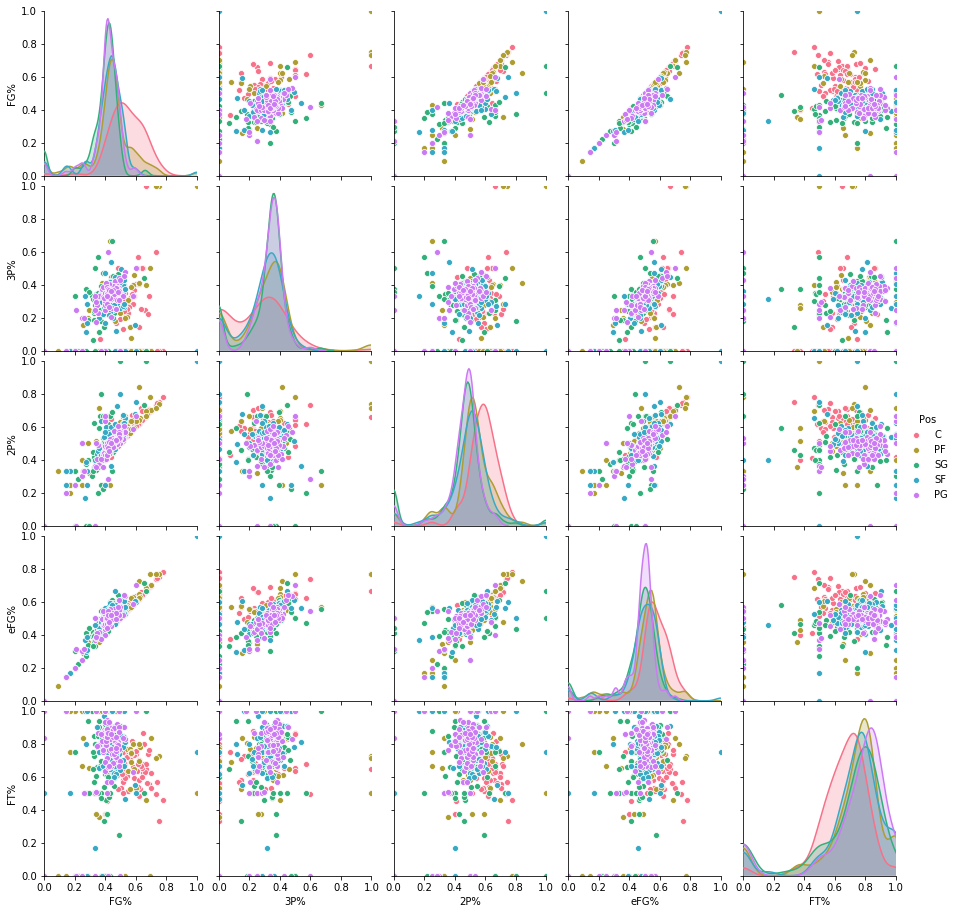

In [18]:
percent_stats = keepPercents + ['Pos']
h = sns.pairplot(basketballData[percent_stats], hue = 'Pos', palette = 'husl')
h.set(xlim = (0,1), ylim = (0,1))

plt.show(h)


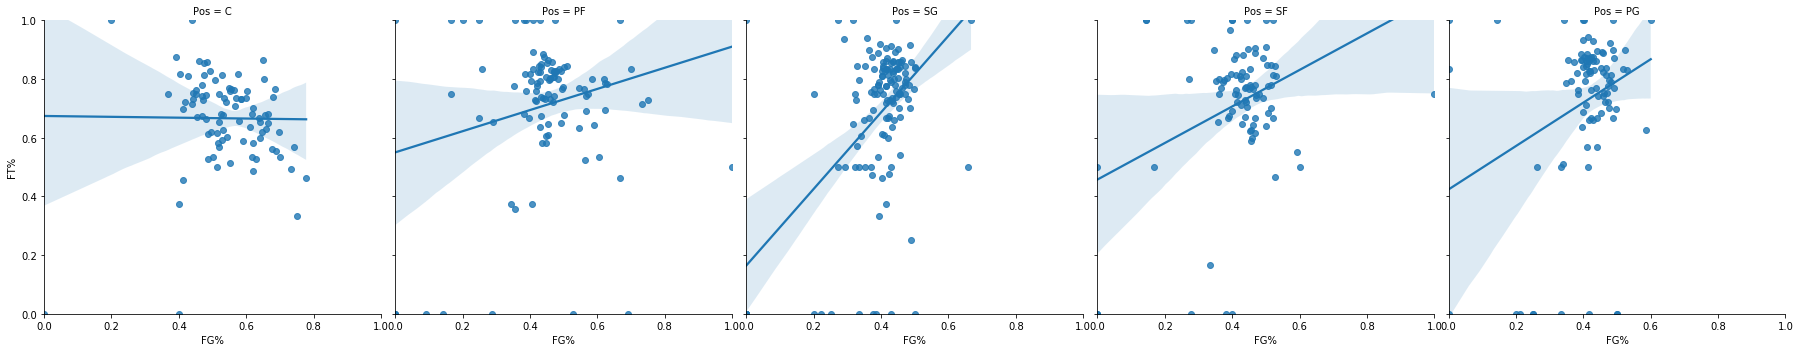

In [19]:

g = sns.lmplot(x='FG%',y='FT%',data=basketballData,col='Pos')
g = (g.set_axis_labels("FG%","FT%").set(xlim = (0,1), ylim = (0,1)))

plt.show(g)


In [20]:
fig = px.scatter(basketballData, x='PTS', y='AST', color = 'Pos', hover_data = ['Player'])
fig.update_layout(title_text = 'Points vs. Assists for 2020 NBA Players')

# Top 20 Graphs and Analysis Metrics

In [21]:
playersTS = basketballData['PTS'] / (2 * ( basketballData['FGA'] + 0.44*basketballData['FTA'] ))

basketballData['TS%'] =  playersTS.round(decimals=2)

sortedTS = basketballData.sort_values(['TS%'], ascending=False)
sortedTS.head(10)

Player Pos   Age   Tm     G   GS      MP     FG    FGA    FG%  \
474        Noah Vonleh  PF  24.0  DEN   4.0  0.0    17.0    3.0    3.0  1.000   
28    Keita Bates-Diop  SF  24.0  DEN   2.0  0.0    19.0    2.0    2.0  1.000   
142       Drew Eubanks  PF  22.0  SAS  14.0  3.0   130.0   21.0   28.0  0.750   
346   Johnathan Motley  PF  24.0  LAC  13.0  0.0    41.0   11.0   15.0  0.733   
394     Shamorie Ponds  PG  21.0  TOR   4.0  0.0    11.0    3.0    5.0  0.600   
329          Eric Mika  PF  25.0  SAC   1.0  0.0    19.0    2.0    3.0  0.667   
108         Tyler Cook  PF  22.0  CLE  11.0  0.0    35.0    7.0   10.0  0.700   
182         Jeff Green  PF  33.0  HOU  10.0  0.0   201.0   41.0   66.0  0.621   
476          Dean Wade  PF  23.0  CLE  12.0  0.0    71.0    9.0   13.0  0.692   
415  Mitchell Robinson   C  21.0  NYK  61.0  7.0  1412.0  253.0  341.0  0.742   

       3P   3PA    3P%     2P    2PA    2P%   eFG%    FT    FTA    FT%    ORB  \
474   1.0   1.0  1.000    2.0    2.0  1.000  1.167   1.0    2.0  0.500    3.0   
28    0.0   0.0  0.000    2.0    2.0  1.000  1.000   3.0    4.0  0.750    0.0   
142   1.0   1.0  1.000   20.0   27.0  0.741  0.768   8.0   11.0  0.727    8.0   
346   1.0   1.0  1.000   10.0   14.0  0.714  0.767   5.0    7.0  0.714    3.0   
394   1.0   2.0  0.500    2.0    3.0  0.667  0.700   2.0    2.0  1.000    0.0   
329   0.0   0.0  0.000    2.0    3.0  0.667  0.667   2.0    2.0  1.000    2.0   
108   0.0   0.0  0.000    7.0   10.0  0.700  0.700   5.0    6.0  0.833    4.0   
182  14.0  34.0  0.412   27.0   32.0  0.844  0.727   8.0   10.0  0.800    9.0   
476   2.0   4.0  0.500    7.0    9.0  0.778  0.769   0.0    1.0  0.000    3.0   
415   0.0   0.0  0.000  253.0  341.0  0.742  0.742  84.0  148.0  0.568  186.0   

       DRB    TRB   AST   STL    BLK   TOV     PF    PTS   TS%  
474    4.0    7.0   1.0   0.0    0.0   2.0    2.0    8.0  1.03  
28     2.0    2.0   0.0   0.0    1.0   0.0    2.0    7.0  0.93  
142   27.0   35.0   5.0   2.0    6.0  10.0   21.0   51.0  0.78  
346    7.0   10.0   8.0   3.0    0.0   5.0    6.0   28.0  0.77  
394    1.0    1.0   2.0   0.0    1.0   0.0    2.0    9.0  0.77  
329    5.0    7.0   0.0   0.0    0.0   0.0    5.0    6.0  0.77  
108    6.0   10.0   1.0   1.0    0.0   1.0    4.0   19.0  0.75  
182   23.0   32.0  12.0   9.0    5.0   9.0   19.0  104.0  0.74  
476   16.0   19.0   2.0   2.0    4.0   3.0    8.0   20.0  0.74  
415  242.0  428.0  36.0  52.0  119.0  37.0  194.0  590.0  0.73

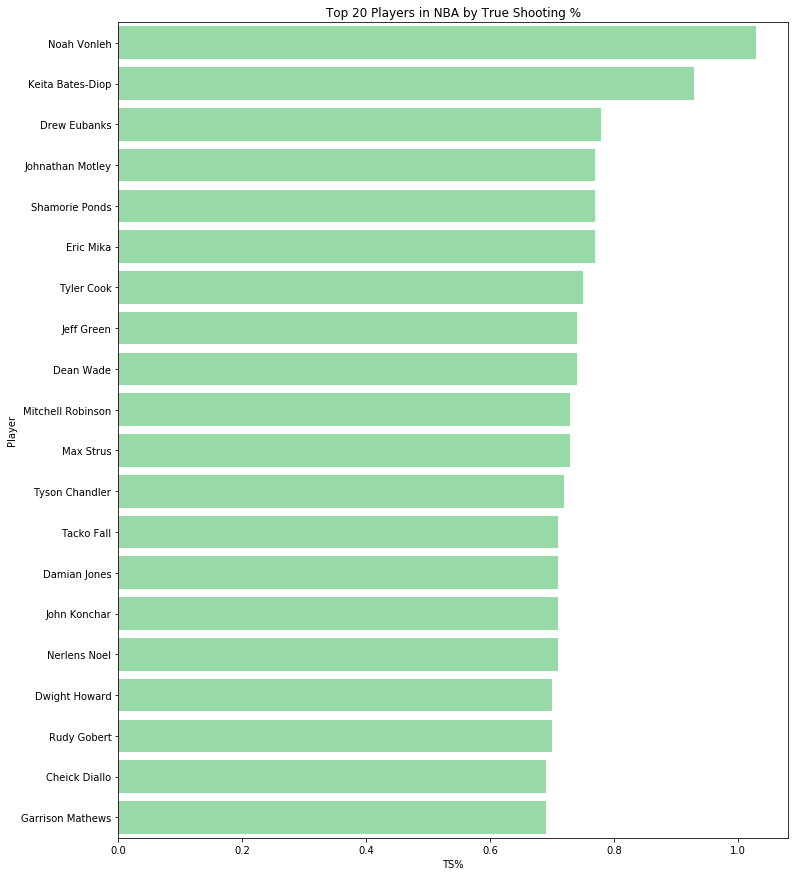

In [22]:
TStop20 = sortedTS.head(20) #select top 20
f, ax = plt.subplots(figsize=(12, 15))
plt.title('Top 20 Players in NBA by True Shooting %')
sns.set_color_codes("pastel")
sns.barplot(x="TS%", y="Player", data=TStop20, color="g")

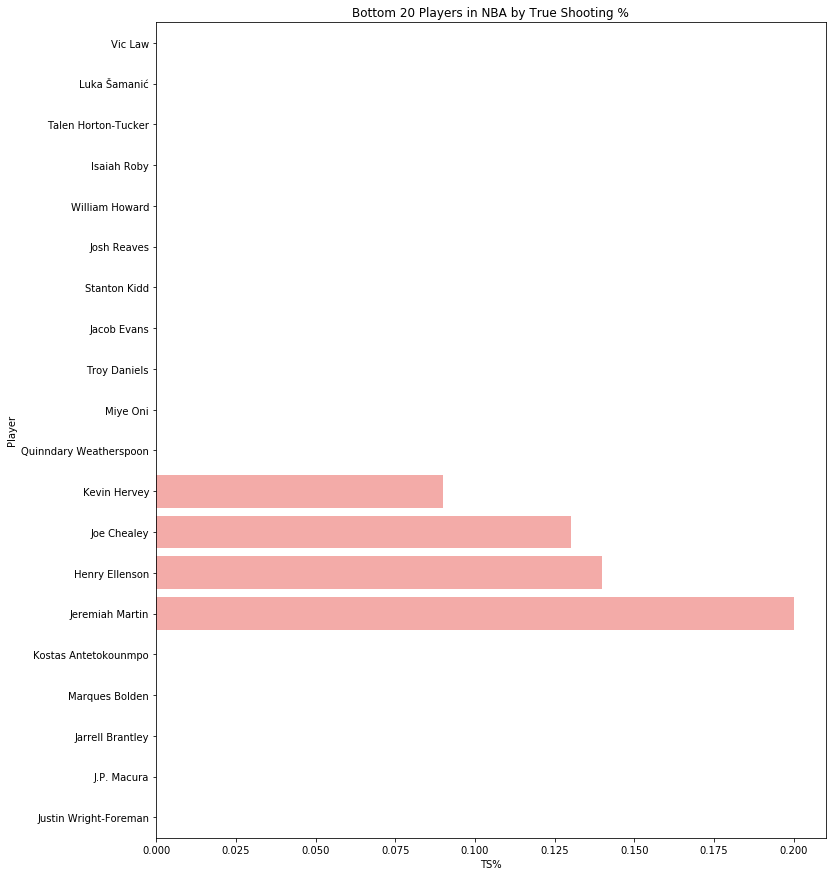

In [23]:
TSbottom20 = sortedTS.tail(20)
f, ax = plt.subplots(figsize=(12, 15))
plt.title('Bottom 20 Players in NBA by True Shooting %')
TSbottom20 = TSbottom20.sort_values(by = 'TS%', ascending = True)

sns.set_color_codes("pastel")
sns.barplot(x="TS%", y="Player", data=TSbottom20, color="r")

Looking at the above percentages and players, it's pretty clear that True Shooting Percentage isn't too accurate. It doesn't take into account whether the player sets up their own shot or depends on assists from others. Let's try doing another metric called the Player Efficiency Rating (PER) and graph it to see what happens

In [24]:
PER_coeff = {
    "FG": 85.910,
    "STL": 53.897,
    "3P": 51.757,
    "FT": 46.845,
    "BLK": 39.190,
    "ORB": 39.190,
    "AST": 34.677,
    "DRB": 14.707,
    "PF": -17.174,
    "FTmiss": -20.091,
    "FGmiss": -39.190,
    "TOV": -53.897
}

playerER = (
    basketballData["FG"]*PER_coeff["FG"] + 
    basketballData["STL"]*PER_coeff["STL"] + 
    basketballData["3P"]*PER_coeff["3P"] + 
    basketballData["BLK"]*PER_coeff["BLK"] + 
    basketballData["ORB"]*PER_coeff["ORB"] + 
    basketballData["AST"]*PER_coeff["AST"] + 
    basketballData["DRB"]*PER_coeff["DRB"] + 
    basketballData["PF"]*PER_coeff["PF"] + 
    (basketballData["FGA"]-basketballData["FG"])*PER_coeff["FGmiss"] + 
    (basketballData["FTA"]-basketballData["FT"])*PER_coeff["FTmiss"] + 
    basketballData["TOV"]*PER_coeff["TOV"]
)

playerER *= (1 / basketballData["MP"])

playerER = playerER.round(decimals=2)

basketballData['PER'] = playerER

sortedPER = basketballData.sort_values(['PER'], ascending=False)
sortedPER.head(10)

Player Pos   Age   Tm     G    GS      MP     FG     FGA  \
394         Shamorie Ponds  PG  21.0  TOR   4.0   0.0    11.0    3.0     5.0   
11   Giannis Antetokounmpo  PF  25.0  MIL  57.0  57.0  1763.0  623.0  1139.0   
346       Johnathan Motley  PF  24.0  LAC  13.0   0.0    41.0   11.0    15.0   
447              Max Strus  SG  23.0  CHI   2.0   0.0     6.0    2.0     3.0   
145             Tacko Fall   C  24.0  BOS   6.0   0.0    24.0    9.0    12.0   
243           LeBron James  PG  35.0  LAL  60.0  60.0  2094.0  586.0  1176.0   
327          Chimezie Metu  PF  22.0  SAS  16.0   0.0    73.0   20.0    35.0   
461     Karl-Anthony Towns   C  24.0  MIN  35.0  35.0  1187.0  316.0   622.0   
234           Kyrie Irving  PG  27.0  BRK  20.0  20.0   658.0  199.0   416.0   
494       Hassan Whiteside   C  30.0  POR  61.0  61.0  1911.0  418.0   676.0   

       FG%     3P    3PA    3P%     2P    2PA    2P%   eFG%     FT    FTA  \
394  0.600    1.0    2.0  0.500    2.0    3.0  0.667  0.700    2.0    2.0   
11   0.547   83.0  271.0  0.306  540.0  868.0  0.622  0.583  361.0  570.0   
346  0.733    1.0    1.0  1.000   10.0   14.0  0.714  0.767    5.0    7.0   
447  0.667    0.0    1.0  0.000    2.0    2.0  1.000  0.667    1.0    1.0   
145  0.750    0.0    0.0  0.000    9.0   12.0  0.750  0.750    1.0    3.0   
243  0.498  133.0  381.0  0.349  453.0  795.0  0.570  0.555  239.0  343.0   
327  0.571    0.0    1.0  0.000   20.0   34.0  0.588  0.571    6.0    8.0   
461  0.508  114.0  277.0  0.412  202.0  345.0  0.586  0.600  180.0  226.0   
234  0.478   56.0  142.0  0.394  143.0  274.0  0.522  0.546   94.0  102.0   
494  0.618    4.0    7.0  0.571  414.0  669.0  0.619  0.621  153.0  225.0   

       FT%    ORB    DRB    TRB    AST   STL    BLK    TOV     PF     PTS  \
394  1.000    0.0    1.0    1.0    2.0   0.0    1.0    0.0    2.0     9.0   
11   0.633  130.0  653.0  783.0  329.0  59.0   58.0  209.0  173.0  1690.0   
346  0.714    3.0    7.0   10.0    8.0   3.0    0.0    5.0    6.0    28.0   
447  1.000    1.0    0.0    1.0    0.0   0.0    0.0    0.0    1.0     5.0   
145  0.333    0.0   11.0   11.0    0.0   0.0    2.0    3.0    5.0    19.0   
243  0.697   59.0  414.0  473.0  636.0  74.0   30.0  239.0  106.0  1544.0   
327  0.750   10.0   16.0   26.0    6.0   1.0    4.0    5.0    4.0    46.0   
461  0.796   95.0  283.0  378.0  153.0  33.0   42.0  110.0  117.0   926.0   
234  0.922   22.0   81.0  103.0  128.0  27.0   10.0   52.0   53.0   548.0   
494  0.680  244.0  625.0  869.0   74.0  24.0  187.0  117.0  179.0   993.0   

      TS%        PER  
394  0.77  29.090000  
11   0.61  28.770000  
346  0.77  26.510000  
447  0.73  25.770000  
145  0.71  25.330000  
243  0.58  25.280001  
327  0.60  24.629999  
461  0.64  24.270000  
234  0.59  24.250000  
494  0.64  23.610001

In [25]:
sortedPER['PER'].describe()
PERtop20 = sortedPER.head(20) #grab the top 20 players

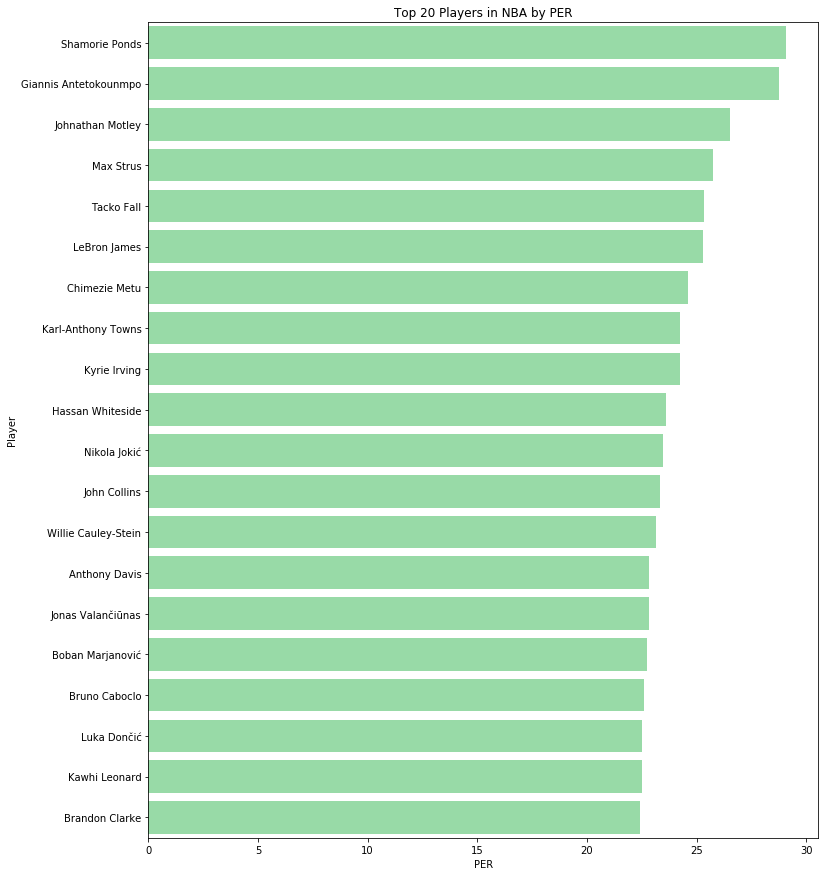

In [26]:
f, ax = plt.subplots(figsize=(12, 15))
plt.title('Top 20 Players in NBA by PER')
sns.set_color_codes("pastel")
sns.barplot(x="PER", y="Player", data=PERtop20, color="g")


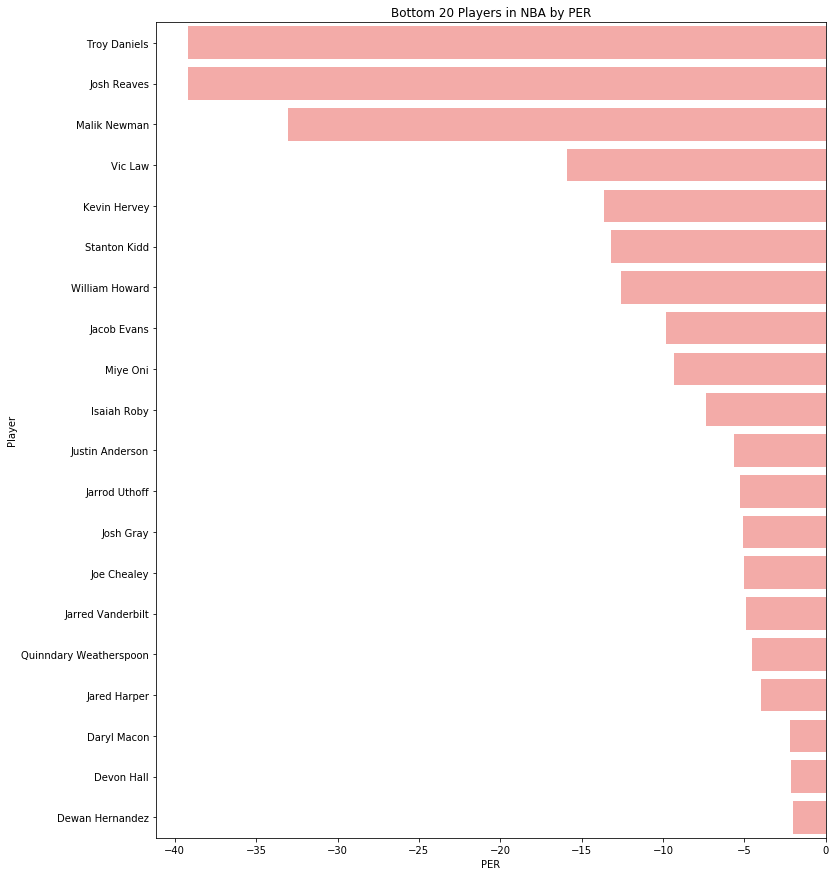

In [27]:
f, ax = plt.subplots(figsize=(12, 15))
PERbottom20 = sortedPER.tail(20)
PERbottom20 = PERbottom20.sort_values(by = 'PER', ascending = True)
plt.title('Bottom 20 Players in NBA by PER')
sns.barplot(x="PER", y="Player", data=PERbottom20, color="r")

Let's try 2 more metrics now, Value added (VA) and Estimated wins added (EWA)

In [28]:
VA_coeff = {
    'PF':11.5,
    'PG':11.0,
    'C':10.6,
    'SF':10.5,
    'SG':10.5
}

PRL = [ VA_coeff[pos] for pos in basketballData['Pos']]

playerVA = (basketballData['MP'] * (basketballData['PER'] - PRL)) / 67
playerVA = playerVA.round(decimals=2)

playerEWA = playerVA/30
playerEWA = playerEWA.round(decimals=1)

basketballData['VA'] = playerVA
basketballData['EWA'] = playerEWA

sortedVA = basketballData.sort_values(['VA'], ascending=False)
sortedVA.head()

Player Pos   Age   Tm     G    GS      MP     FG     FGA  \
11   Giannis Antetokounmpo  PF  25.0  MIL  57.0  57.0  1763.0  623.0  1139.0   
243           LeBron James  PG  35.0  LAL  60.0  60.0  2094.0  586.0  1176.0   
254           Nikola Jokić   C  24.0  DEN  65.0  65.0  2101.0  512.0   969.0   
494       Hassan Whiteside   C  30.0  POR  61.0  61.0  1911.0  418.0   676.0   
191           James Harden  SG  30.0  HOU  61.0  61.0  2241.0  603.0  1386.0   

       FG%     3P    3PA    3P%     2P    2PA    2P%   eFG%     FT    FTA  \
11   0.547   83.0  271.0  0.306  540.0  868.0  0.622  0.583  361.0  570.0   
243  0.498  133.0  381.0  0.349  453.0  795.0  0.570  0.555  239.0  343.0   
254  0.528   71.0  226.0  0.314  441.0  743.0  0.594  0.565  218.0  268.0   
494  0.618    4.0    7.0  0.571  414.0  669.0  0.619  0.621  153.0  225.0   
191  0.435  271.0  769.0  0.352  332.0  617.0  0.538  0.533  619.0  719.0   

       FT%    ORB    DRB    TRB    AST    STL    BLK    TOV     PF     PTS  \
11   0.633  130.0  653.0  783.0  329.0   59.0   58.0  209.0  173.0  1690.0   
243  0.697   59.0  414.0  473.0  636.0   74.0   30.0  239.0  106.0  1544.0   
254  0.813  155.0  508.0  663.0  446.0   77.0   43.0  202.0  200.0  1313.0   
494  0.680  244.0  625.0  869.0   74.0   24.0  187.0  117.0  179.0   993.0   
191  0.861   64.0  324.0  388.0  450.0  106.0   53.0  273.0  206.0  2096.0   

      TS%        PER      VA   EWA  
11   0.61  28.770000  454.43  15.1  
243  0.58  25.280001  446.30  14.9  
254  0.60  23.450001  402.95  13.4  
494  0.64  23.610001  371.08  12.4  
191  0.62  20.330000  328.79  11.0

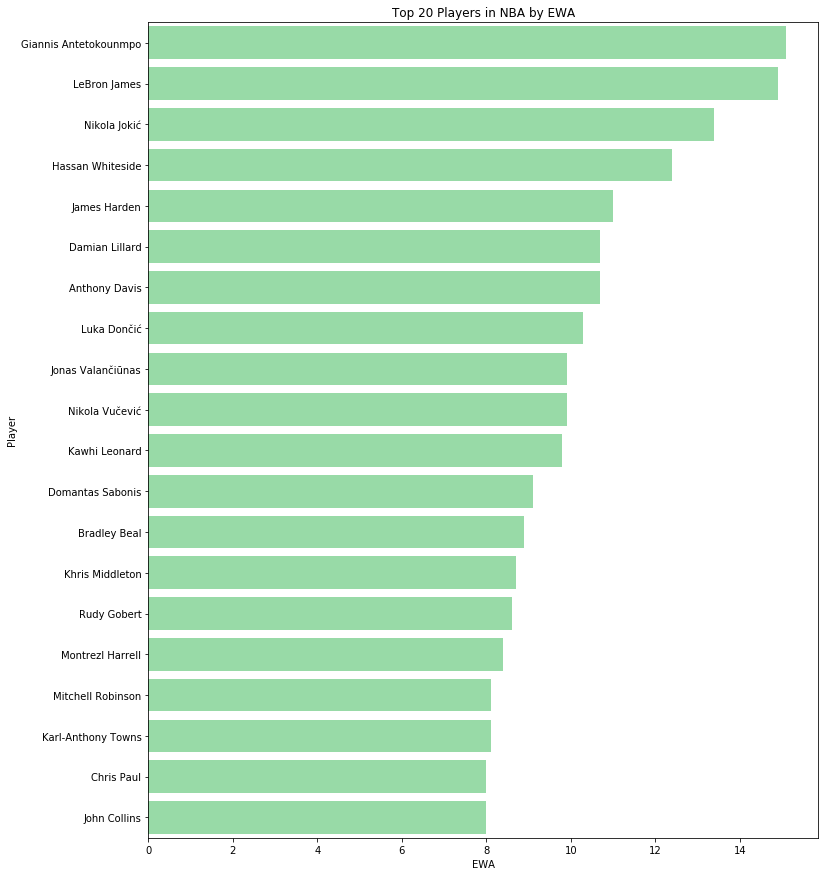

In [29]:
VAtop20 = sortedVA.head(20) #grab the top 20 players
f, ax = plt.subplots(figsize=(12, 15))
plt.title('Top 20 Players in NBA by EWA')
sns.set_color_codes("pastel")
sns.barplot(x="EWA", y="Player", data=VAtop20, color="g")


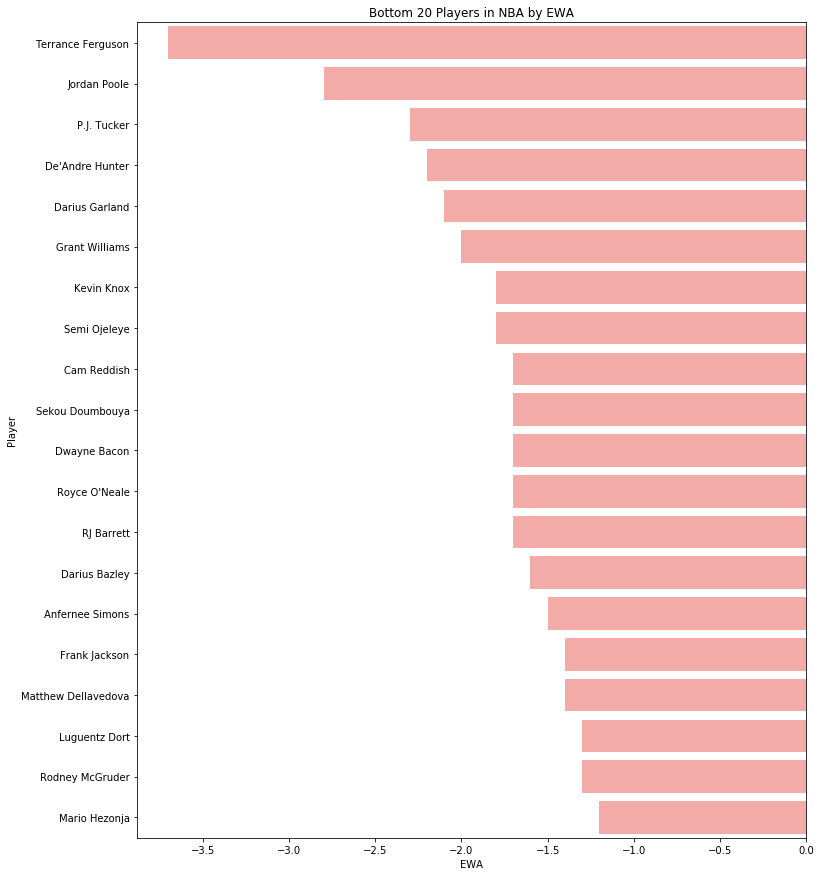

In [30]:
VAbottom20 = sortedVA.tail(20) #bottom 20 players
VAbottom20 = VAbottom20.sort_values(by = 'EWA', ascending = True)
f, ax = plt.subplots(figsize=(12, 15))
plt.title('Bottom 20 Players in NBA by EWA')
sns.set_color_codes("pastel")
sns.barplot(x="EWA", y="Player", data=VAbottom20, color="r")

In [31]:
basketballData.head()

Player Pos   Age   Tm     G    GS      MP     FG    FGA  \
0              Steven Adams   C  26.0  OKC  58.0  58.0  1564.0  262.0  443.0   
1               Bam Adebayo  PF  22.0  MIA  65.0  65.0  2235.0  408.0  719.0   
2         LaMarcus Aldridge   C  34.0  SAS  53.0  53.0  1754.0  391.0  793.0   
3  Nickeil Alexander-Walker  SG  21.0  NOP  41.0   0.0   501.0   77.0  227.0   
4             Grayson Allen  SG  24.0  MEM  30.0   0.0   498.0   79.0  176.0   

     FG%    3P    3PA    3P%     2P    2PA    2P%   eFG%     FT    FTA    FT%  \
0  0.591   1.0    3.0  0.333  261.0  440.0  0.593  0.593  108.0  183.0  0.590   
1  0.567   1.0   13.0  0.077  407.0  706.0  0.576  0.568  236.0  342.0  0.690   
2  0.493  61.0  157.0  0.389  330.0  636.0  0.519  0.532  158.0  191.0  0.827   
3  0.339  40.0  117.0  0.342   37.0  110.0  0.336  0.427   17.0   28.0  0.607   
4  0.449  33.0   91.0  0.363   46.0   85.0  0.541  0.543   30.0   35.0  0.857   

     ORB    DRB    TRB    AST   STL   BLK    TOV     PF     PTS   TS%  \
0  196.0  347.0  543.0  141.0  50.0  65.0   86.0  111.0   633.0  0.60   
1  165.0  518.0  683.0  333.0  78.0  85.0  185.0  164.0  1053.0  0.61   
2  103.0  289.0  392.0  129.0  36.0  87.0   74.0  128.0  1001.0  0.57   
3    8.0   72.0   80.0   74.0  11.0   7.0   40.0   46.0   211.0  0.44   
4    5.0   61.0   66.0   43.0   6.0   1.0   23.0   36.0   221.0  0.58   

         PER      VA  EWA  
0  19.400000  205.42  6.8  
1  18.420000  230.84  7.7  
2  18.389999  203.94  6.8  
3   8.870000  -12.19 -0.4  
4  11.410000    6.76  0.2

In [40]:
figure = px.scatter(basketballData, x='PER', y = 'EWA', hover_data = ['Player'], color = 'Pos')
figure.update_layout(title_text = 'PER % vs. Estimated Wins Added for 2020 NBA Players')
figure.update_xaxes(tick0=0)
figure.show()


In [43]:
figure = px.scatter(basketballData, x='PER', y = 'TS%', hover_data = ['Player'], color = 'Pos', color_continuous_scale ='viridis')
figure.update_layout(title_text = 'True Shooting % vs. PER for 2020 NBA Players')